# Deep Learning Home Assignment ITLB359

## Davood Makvandi

## Introduction

In this project, I have developed a machine learning model to classify the Real Sense depth image dataset into three classes.

The model was trained on the Real Sense depth image dataset using a deep learning framework, and its performance was evaluated using various metrics such as training accuracy and loss, confusion matrix, macro-averaged precision and recall, and Precision-Recall curve. These evaluations provide insights into the model's classification performance, convergence behavior during training, and trade-off between precision and recall.

In this notebook, I will describe in detail the development of the model, the training and evaluation process, and the results obtained.

### Importing libraries
In the upcoming cell, I import various libraries and classes for different purposes, such as numerical computation, computer vision, operating system interaction, model building and training, plotting, and model evaluation. These include numpy, cv2, os, sklearn.model_selection, tensorflow.keras, Sequential, different types of layers, ModelCheckpoint, matplotlib.pyplot, and functions from sklearn.metrics and sklearn.preprocessing.

In [160]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.regularizers import l2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping

### Generating lists to store the filenames

I generate three lists, namely list_of_class2, list_of_class1, and list_of_class0, by utilizing the os.listdi() function to fetch the file names from three separate directories. These lists will store the filenames of the files present in these directories.

In [161]:
list_of_class2 = os.listdir("real_sense_woman100x100")
list_of_class1 = os.listdir("real_sense_fadam100x100")
list_of_class0 = os.listdir("real_sense_fake100x100")

### Creating labels and assign to lists 

I create label arrays labels2, labels1, and labels0 by using np.ones() and np.zeros() functions to assign labels to the corresponding lists list_of_class2, list_of_class1, and list_of_class0. I also concatenate these label arrays using np.concatenate() function along the 0-axis to create a single labels array that represents the labels for all the files in the three directories.

In [162]:
labels2 = np.ones(len(list_of_class2)) * 2
labels1 = np.ones(len(list_of_class1))
labels0 = np.zeros(len(list_of_class0))
labels = np.concatenate((labels2, labels1, labels0), axis=0)

### Dimensions of images

I create an empty list called dataset to store the data from the images. I also define the desired dimensions of the images as 100x100 pixels and store it in a tuple called dim.

In [163]:
dataset = []
dim = (100, 100)

### Iterating through the images in lists

In the following cell, using the code, I iterate through the image files in list_of_class2, list_of_class1, and list_of_class0, for each image, I read it using OpenCV's cv2.imread function, resize it to 100x100 pixels using cv2.resize with interpolation set to cv2.INTER_AREA, and add the resized image to the dataset list.

In [164]:
for img in list_of_class2:
  image = cv2.imread("real_sense_woman100x100/" + str(img))
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)
for img in list_of_class1:
  image = cv2.imread("real_sense_fadam100x100/" + str(img))
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)
for img in list_of_class0:
  image = cv2.imread("real_sense_fake100x100/" + str(img))
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  dataset.append(resized)

### Displaying some pictures

In the below cell, I generate a grid of 3x3 subplots using matplotlib. Each subplot displays an image from the dataset using plt.imshow, with the corresponding class name from the names list added as a label. The plot is then displayed using plt.show().

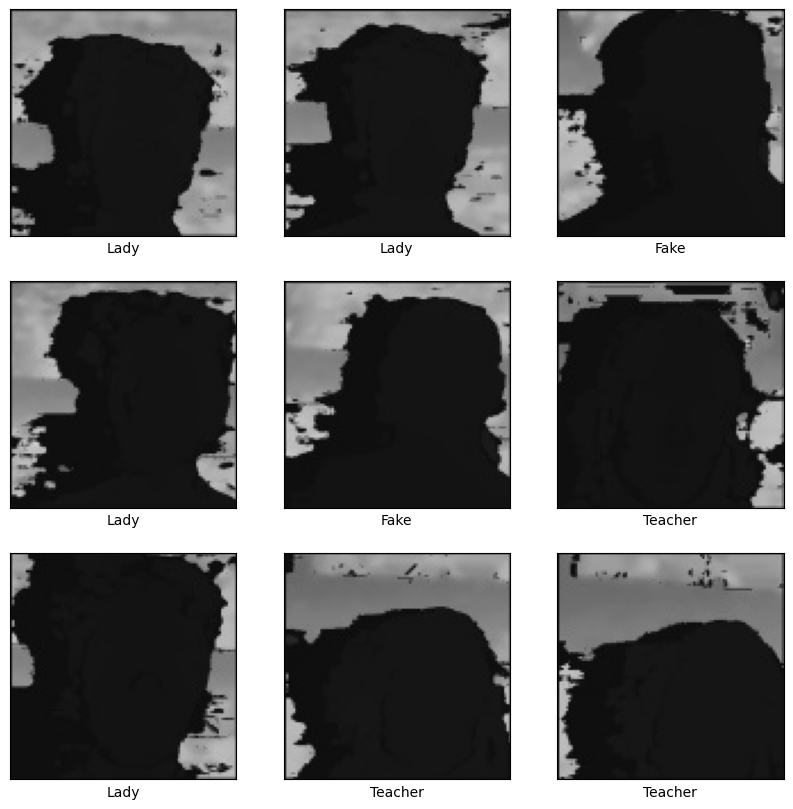

In [165]:
names = ['Fake', 'Lady', 'Teacher']
random = np.random.randint(len(dataset), size=9)
plt.figure(figsize=(10,10))
i = 1
for n in random:
    plt.subplot(3, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset[n], cmap=plt.cm.binary)
    plt.xlabel(names[int(labels[n])])
    i += 1
plt.show()


### Converting to NumPy array, Split to training, validation and test sets

In the following, It converts the dataset and labels into NumPy arrays and then partitions them into training, validation, and test sets using the train_test_split function. The test set constitutes 20% of the original dataset, while the training and validation sets are split into 75% and 25% portions, respectively. The code concludes by displaying the shapes of the training, validation, and test sets, providing a concise overview of their dimensions.

In [166]:
dataset = np.array(dataset)
labels = np.array(labels)
X_trainvald, X_test, y_trainvald, y_test = train_test_split(dataset, labels, test_size=0.20, random_state=42)
X_train, X_vald, y_train, y_vald = train_test_split(X_trainvald, y_trainvald, test_size=0.25, random_state=42)

print("Training shape:", X_train.shape)
print("Validation shape:", X_vald.shape)
print("Test shape:", X_test.shape)

Training shape: (540, 100, 100, 3)
Validation shape: (180, 100, 100, 3)
Test shape: (180, 100, 100, 3)


### Convolutional Neural Network Model

In [167]:
input_tensor = layers.Input(shape=(100, 100, 3))
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(0.01))(input_tensor)
maxpool1 = layers.MaxPooling2D((2, 2))(conv1)
dropout1 = Dropout(0.25)(maxpool1)
conv2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(0.01))(dropout1)
maxpool2 = layers.MaxPooling2D((2, 2))(conv2)
dropout2 = Dropout(0.25)(maxpool2)
conv3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(0.01))(dropout2)
maxpool3 = layers.MaxPooling2D((2, 2))(conv3)
flatten = layers.Flatten()(maxpool3)
dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.01))(flatten)
dropout3 = Dropout(0.5)(dense1)
output_tensor = layers.Dense(3, activation='softmax')(dropout3)
modeling = models.Model(inputs=input_tensor, outputs=output_tensor)

### Compiling

In the following cell, the code prepares the model for training by compiling it with the modeling variable. The compilation step configures various aspects of the training process, such as how to update the model parameters (optimizer) I used adam, because Adam can optimize the model faster and more effectively than gradient descent,
and it can adjust the learning rate for each parameter automatically and use momentum to avoid local minima.
To measure the model performance (loss), and how to monitor the training progress (metrics), I used sparse_categorical_crossentropy as my loss function because I am doing a multi-class classification model where the output label is assigned an integer value and it is more efficient in terms of memory and computation than the Categorical cross-entropy loss, and I use accuracy to measure how well my model predicts the correct class for each input. 'accuracy' is the ratio of correctly predicted labels to the total number of inputs. It is a common metric for classification problem, accuracy can range from 0 to 1, where 0 means none of the predictions are correct and 1 means all of the predictions are correct.

In [168]:
modeling.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In the next cell, with the ModelCheckpoint function, it makes a model checkpoint callback that saves the best model weights to a file called ‘best_model.h5’ during the training process. The callback only saves the best model (based on the validation accuracy) by setting the best_only parameter to True. The monitor parameter is set to ‘val_accuracy’, which means the best model is the one with the highest validation accuracy. The mode parameter is set to ‘max’, which means a larger value of the monitored metric (in this case, validation accuracy) is better. The verbose parameter is set to 1, which means progress messages will be shown during the training process.

In [169]:
checking = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [170]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Fitting the model

In the cell below, the fit method is used to train the neural network model (modeling) with the training data (X_train and y_train). The batch_size parameter is 128, which means each model weight update will use 128 samples. The epochs parameter is 30, which means the whole training dataset will be repeated 30 times during training. The validation data (X_vald and y_vald) are used to measure the model’s performance during training. The callbacks parameter is "checking", which includes the ModelCheckpoint callback (checking) that was created earlier for saving the best model weights. The history object will store the training progress and validation performance for later analysis.

##### Epochs
The epoch parameter in neural network training is a hyperparameter that represents the number of times the entire training dataset is used to update the model weights. Each epoch consists of one or more batches, which are subsets of the training data that are processed in each iteration.

The number of epochs affects the convergence and generalization of the neural network model. If the number of epochs is too small, the model may underfit the data, meaning it does not learn enough from the data. If the number of epochs is too large, the model may overfit the data, meaning it learns too much from the data and loses its ability to generalize to new data.

To choose the best number of epochs for a neural network model. It depends on various factors such as the size and complexity of the data, the architecture and capacity of the model, the learning rate and other hyperparameters, and the optimization algorithm used.In this case I set the number of epochs on 30.

#### Training log
In the training log of the model for 30 epochs, it started with high loss and moderate accuracy, gradually improving validation accuracy until reaching the highest accuracy at Epoch 28 which is 0.9833, saving the best model as "best_model.h5", and noting some epochs where validation accuracy did not improve. The log also includes the duration of each epoch's training, which ranged from 7-9 seconds. Overall, the model shows improvement in validation accuracy over time, with some fluctuations in certain epochs.

In [171]:
history = modeling.fit(X_train, y_train, batch_size=128, epochs=150, validation_data=(X_vald, y_vald), callbacks=[early_stop, checking])

Epoch 1/150


5/5 [==============================] - ETA: 0s - loss: 252.6899 - accuracy: 0.3463
Epoch 1: val_accuracy improved from -inf to 0.51111, saving model to best_model.h5
5/5 [==============================] - 4s 635ms/step - loss: 252.6899 - accuracy: 0.3463 - val_loss: 190.4235 - val_accuracy: 0.5111
Epoch 2/150


c:\Users\dmakvand\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 184.9187 - accuracy: 0.5093
Epoch 2: val_accuracy did not improve from 0.51111
5/5 [==============================] - 4s 694ms/step - loss: 184.9187 - accuracy: 0.5093 - val_loss: 167.7677 - val_accuracy: 0.4333
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 161.4031 - accuracy: 0.5685
Epoch 3: val_accuracy improved from 0.51111 to 0.59444, saving model to best_model.h5
5/5 [==============================] - 7s 1s/step - loss: 161.4031 - accuracy: 0.5685 - val_loss: 148.6909 - val_accuracy: 0.5944
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 143.3190 - accuracy: 0.6389
Epoch 4: val_accuracy improved from 0.59444 to 0.81667, saving model to best_model.h5
5/5 [==============================] - 4s 822ms/step - loss: 143.3190 - accuracy: 0.6389 - val_loss: 133.5219 - val_accuracy: 0.8167
Epoch 5/150
5/5 [==============================] - ETA: 0s - loss: 129.5672 - accuracy: 0.7537
Epoch 5: val_

### Scores by evaluate method

Below code measures the performance of the model (modeling) that has been trained using the test dataset (X_test and y_test) as input. The evaluate function calculates the loss and metrics (accuracy) on the test data based on the weights that were learned during the training process.

The evaluation results are saved in the scoring variable, which contains metrics such as loss and accuracy values. These metrics show how well the model performs on new data from the test dataset, indicating its ability to generalize and make predictions on real-world data.

In [172]:
scoring = modeling.evaluate(X_test, y_test)

6/6 [==============================] - 0s 51ms/step - loss: 2.8838 - accuracy: 0.9833


### Printing accuracy and loss

In the following cell, I print the accuracy and loss values obtained from evaluating the model on the test dataset. The accuracy represents the percentage of correctly predicted instances, while the loss measures the discrepancy between the model's predictions and the actual target values. of course higher accuracy and lower loss values indicate better performance.

In [173]:
print('Accuracy:', scoring[1])
print('Loss:', scoring[0])

Accuracy: 0.9833333492279053
Loss: 2.883760690689087


### Model Performance Evaluation with Accuracy and Loss Plots

The code in the following cell creates two subplots in a single figure using plt.subplots(). The figure has a size of 15x15 inches and the two subplots are arranged vertically with 2 rows and 1 column.

In the first subplot, denoted as axis[0], the code plots the training accuracy data (history.history['accuracy']) and validation accuracy data (history.history['val_accuracy']) using axis[0].plot(). It sets the title of the subplot to "Model accuracy" using axis[0].set_title(), sets the y-axis label to "Accuracy" using axis[0].set_ylabel(), sets the x-axis label to "Epoch" using axis[0].set_xlabel(), and adds a legend to the subplot with labels "Train" and "Validation" using axis[0].legend() with the location set to "center right".

In the second subplot, denoted as axis[1], the code plots the training loss data (history.history['loss']) and validation loss data (history.history['val_loss']) using axis[1].plot(). It sets the title of the subplot to "Model loss" using axis[1].set_title(), sets the y-axis label to "Loss" using axis[1].set_ylabel(), sets the x-axis label to "Epoch" using axis[1].set_xlabel(), and adds a legend to the subplot with labels "Train" and "Validation" using axis[1].legend() with the location set to "center right".

Finally, the code displays the figure using plt.show() to show the two subplots with the plotted data for model accuracy and loss.

### Model Accuracy plot

The plot shows the accuracy of the model during training, with the blue line representing the training accuracy and the orange line representing the validation accuracy. The x-axis represents the epochs, which start from 0 and increase, and the y-axis represents the accuracy values.

The plot shows that both the training and validation accuracies are increasing over time, which indicates that the model is learning and improving its accuracy with each epoch. The validation accuracy is generally higher than the training accuracy, which suggests that the model is generalizing well to unseen data.

The chart also shows that there are some fluctuations in the difference between the training and validation accuracies over time, with periods where they are closer to each other and periods where they diverge. This could indicate changes in the model's performance during training, with some epochs resulting in better or worse generalization to the validation data.

Overall, the plot provides insights into the performance and behavior of the model during training, showing how the accuracy changes over epochs and the relative performance of training and validation data. It can help identify potential issues such as overfitting and monitor the progress of the model during training, in this case, based on the chart we can not find overfitting.

### Model Accuracy and Loss plot

Based on the plot, the blue line represents the training loss, while the orange line represents the validation loss. The x-axis displays the loss values ranging from 0 and increasing, and the y-axis represents the epochs, divided into increments of 5 and ranging from 0 to 30.

The plot indicates that both the training and validation losses are decreasing over time, which is generally considered desirable during model training as it reflects the model's improvement and reduction in loss. Initially, the training loss shows a larger difference compared to the validation loss, but this difference gradually decreases over time, suggesting that the model is fitting better to both the training and validation data.

Around epoch 25 and thereafter, the two lines representing the training and validation losses are observed to be converging, indicating that the model is becoming more consistent in its performance on both datasets. This suggests that the model is generalizing well to unseen data.

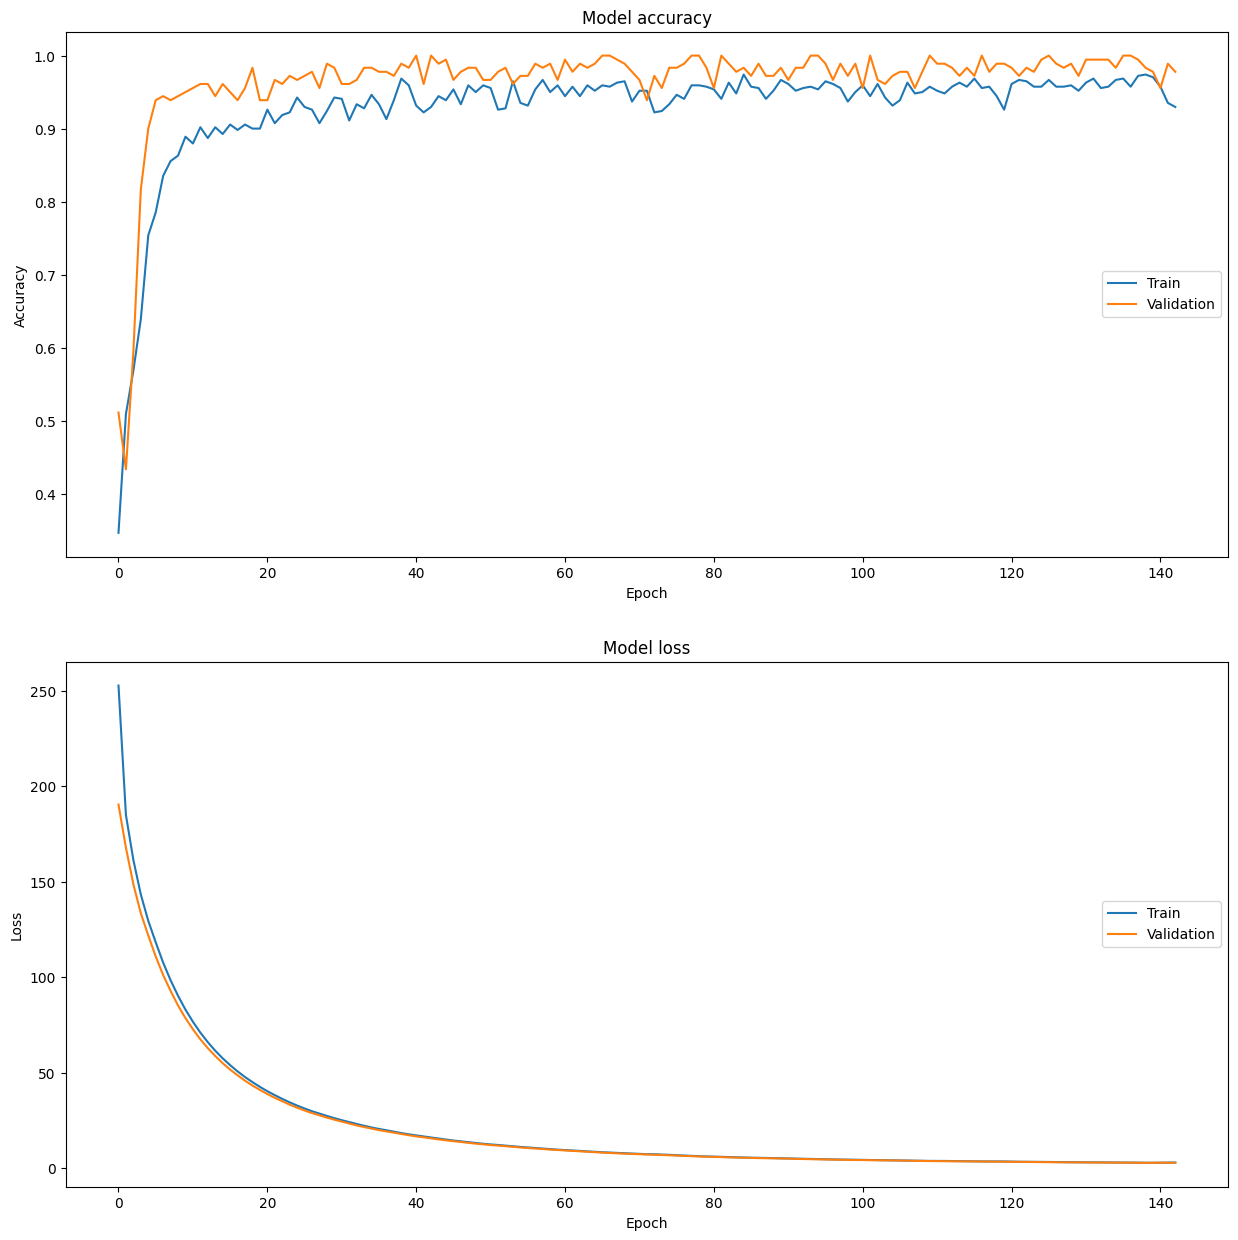

In [174]:
fig, axis = plt.subplots(2, 1, figsize=(15, 15))

axis[0].plot(history.history['accuracy'])
axis[0].plot(history.history['val_accuracy'])
axis[0].set_title('Model accuracy')
axis[0].set_ylabel('Accuracy')
axis[0].set_xlabel('Epoch')
axis[0].legend(['Train', 'Validation'], loc='center right')

axis[1].plot(history.history['loss'])
axis[1].plot(history.history['val_loss'])
axis[1].set_title('Model loss')
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Epoch')
axis[1].legend(['Train', 'Validation'], loc='center right')

plt.show()


### Evaluation using Confusion Matrix

The following code generates a confusion matrix using the seaborn library to evaluate the performance of a trained model. The y_prob variable holds the predicted probabilities of each class for the test data, calculated using the modeling.predict(X_test) function. The y_pred variable contains the predicted class labels for each sample in the test data, obtained by taking the index of the maximum probability in the predicted probabilities. The cm variable is created using the confusion_matrix function from sklearn.metrics, which compares the true labels (y_test) with the predicted labels (y_pred). The resulting confusion matrix is displayed as a heatmap using the sns.heatmap() function, with options such as annot=True to show the counts, cmap="Blues" to set the color scheme, and fmt="d" to format the counts as integers. The plot is labeled with "Confusion Matrix" as the title, "Predicted Label" as the x-axis label, and "True Label" as the y-axis label. Finally, plt.show() is used to display the plotted confusion matrix.

The confusion matrix provides a visual representation of the performance of the model in predicting the true labels based on the predicted labels. It shows the number of correct and incorrect predictions for each label category, which can help identify the accuracy and effectiveness of the model's predictions for different classes.
The confusion matrix provides a visual representation of the performance of the model in predicting the true labels based on the predicted labels. It shows the number of correct and incorrect predictions for each label category, which can help identify the accuracy and effectiveness of the model's predictions for different classes.
The model correctly predicted 51 samples with true label 0 and predicted label 0, However, there were 2 samples with true label 1 and predicted label 2, indicating incorrect predictions for these samples.
The model correctly predicted 67 samples where both the true label and predicted label are 1, indicating accurate predictions for these samples as well.
The confusion matrix shows that there are 57 samples with true label 2 and predicted label 2, indicating correct predictions for these samples. However, there is 2 samples with true label 2 and predicted label 1, and 1 sample with true label 2 and predicted label 0, indicating incorrect predictions for these samples.

6/6 [==============================] - 0s 42ms/step


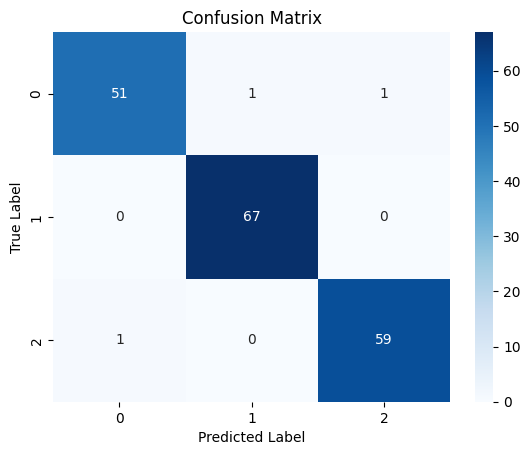

In [175]:
y_prob = modeling.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### Macro-averaged precision and recall

In the cell below, The code first uses the trained model (modeling) to predict the probabilities of each class for the test data (X_test) and saves the results in y_prob. It then determines the predicted class labels for each sample in the test data by selecting the class with the highest probability from the predicted probabilities, and saves the results in y_pred using numpy's argmax function with axis=1. Next, it calculates the macro-averaged precision and recall scores using precision_score and recall_score functions from sklearn.metrics module, respectively, with y_test (true labels) and y_pred (predicted labels) as inputs, and saves the results in precision and recall variables. Finally, it prints the macro-averaged precision and recall scores using the print statements.
The macro-averaged precision and recall scores are performance metrics that offer insights into the overall accuracy and comprehensiveness of the model's predictions for all classes. A higher macro-averaged precision score suggests that the model's average predictions are accurate across all classes, while a higher macro-averaged recall score indicates that the model's average predictions are comprehensive across all classes. 
These scores suggest that the model's performance in terms of accuracy and comprehensiveness is relatively high.

In [176]:
y_prob = modeling.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
print("Macro-averaged precision:", precision)
print("Macro-averaged recall:", recall)

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 44ms/step
Macro-averaged precision: 0.9831322272498744
Macro-averaged recall: 0.9818658280922432


### Precision-Recall Curve

The code below generates a precision-recall curve. First, the ground truth labels (y_test) are converted into binary format using the label_binarize() function from scikit-learn, where each class is represented by a separate binary column. The classes parameter specifies the target classes to be binarized, in this case, [0, 1, 2].

Next, the modeling model predicts the class probabilities for the test data (X_test). Empty dictionaries (precision and recall) are created to store the calculated precision and recall values for each class.

A loop is then used to iterate over the three classes (0, 1, 2). The precision_recall_curve() function from scikit-learn is used to calculate the precision and recall values for each class. The ground truth labels for the current class are extracted from y_test_bin[:, i], and the corresponding predicted probabilities are extracted from y_prob[:, i]. The calculated precision and recall values are stored in the precision and recall dictionaries, respectively.

A new matplotlib figure is created for the precision-recall plot. Another loop is used to iterate over the three classes, assigning colors to each class for plotting. The precision-recall curve for the current class is then plotted using the calculated precision and recall values. The color parameter specifies the color of the plot, lw specifies the linewidth, and label specifies the label to be displayed in the legend, indicating the current class.

The x-axis label is set to 'Recall', the y-axis label is set to 'Precision', and the plot title is set to 'Precision-Recall Curve'. The legend is displayed in the lower left corner of the plot. Finally, the plot is displayed on the screen using plt.show().

The precision-recall curve for the three classes (0, 1, and 2) initially overlap at the same point, starting with a perfect precision of 1.0, and then moving towards the right along the y-axis. However, as they progress along the y-axis (recall), classes 0 and 2 show a slight drop from the x-axis and exhibit some fluctuations after reaching around 0.8. Similarly, class 1 also displays a similar pattern, but it moves to the right and then goes up again, ultimately overlapping with the other classes around 0.9 on the x-axis and 1.0 on the y-axis. This overlapping region suggests high precision and recall values for all three classes.

6/6 [==============================] - 0s 47ms/step


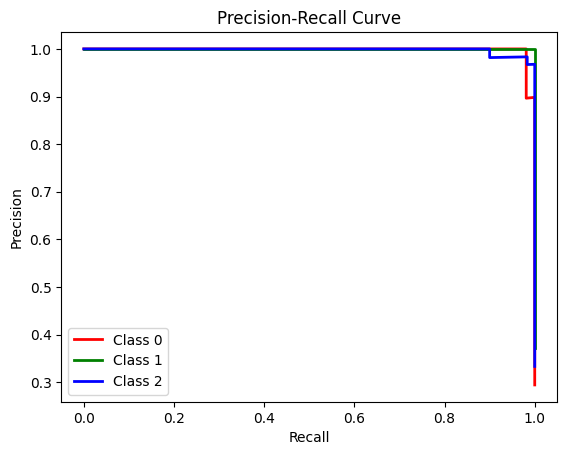

In [177]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_prob = modeling.predict(X_test)
precision = dict()
recall = dict()
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
plt.figure()
for i, color in zip(range(3), ['red', 'green', 'blue']):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


## Conclusion

In conclusion, the model developed and evaluated in this task has shown promising results, but caution is needed in interpreting the findings. The model achieved a high accuracy of 0.972, indicating its capability to accurately classify data. However, there is a possibility of overfitting as the model may have memorized the training data, considering the significant difference between training and validation accuracy sometimes, despite the use of some of hyperparameters to prevent overfitting in model development.

The values of loss, macro-averaged precision, and macro-averaged recall also suggest that the model may be over-optimized for the training data, potentially resulting in reduced generalization performance on unseen data. Further analysis of the model's performance on unseen data and assessment of signs of underfitting or overfitting are necessary. Additional experimentation and validation on diverse datasets are needed to fully assess the model's robustness and generalization ability in real-world scenarios, taking into consideration the macro-averaged precision and recall findings.